# Análise de um e-commerce brasileiro 

Neste notebook vamos explorar uma base de dados de e-comerce e trazer pontos que visam otimizar a venda de produtos e a experiência do cliente. As análises terão dois focos, vendas e logística. Além disso, houve uma preocupação em deixar as análises de forma mais didática possível e possibilitar com que outras pessoas construam novas análises.

## Índice
1. **Dataset e organização de dados**
2. **Importando bibliotecas**
3. **Importando dados**
4. **Explorando o dataset**  
    4.1 Análise por estado   
    4.2 Análise por categoria     
5. **Análise temporal**   
    5.1 Receita por mês   
    5.2 Categorias mais vendidas por mês     
6. **Logística**    
    6.1 Relação entre tempo de entrega receita por estado    
    6.2 Performance geral das entregas    
    6.2 Performance das entregas por estado      
    6.3 Performance das entregas por categoria     
    6.5 Etapas do processo de entregas    
    

***

## 1. Dataset e organização de dados

   O dataset utilizado foi o [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce). O dataset é composto por dados de pedidos feitos no [e-commerce da Olist](https://olist.com/pt-br/), a maior loja de departamento do Brasil, com certa de 100.000 pedidos feitos de 2016 a 2018. Os dados estão organizados em 9 tabelas, vamos detalhar cada uma em seguida. Vale ressaltar que os dados são reais e anonimizados.


#### Organização dos dados    
Tabelas
* `customers`
* `geolocation`
* `order_items`
* `order_payments`
* `order_reviews`
* `orders`
* `products`
* `sellers`
* `product_category_name_translation`

#### As tabelas se relacionam como mostrado na figura abaixo:

<img src="olist_db.png" alt="Drawing" align="left" style="width: 600px;"/>

***

## 2. Importando bibliotecas

In [247]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker
import textwrap as tw 
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta

BASE_DATA_PATH = "data/"

***

## 3. Importando dados

In [41]:
customers = pd.read_csv(f"{BASE_DATA_PATH}/olist_customers_dataset.csv")
geolocation = pd.read_csv(f"{BASE_DATA_PATH}/olist_geolocation_dataset.csv")
order_items = pd.read_csv(f"{BASE_DATA_PATH}/olist_order_items_dataset.csv")
order_payments = pd.read_csv(f"{BASE_DATA_PATH}/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv(f"{BASE_DATA_PATH}/olist_order_reviews_dataset.csv")
orders = pd.read_csv(f"{BASE_DATA_PATH}/olist_orders_dataset.csv")
products = pd.read_csv(f"{BASE_DATA_PATH}/olist_products_dataset.csv")
sellers = pd.read_csv(f"{BASE_DATA_PATH}/olist_sellers_dataset.csv")
product_category_translation = pd.read_csv(f"{BASE_DATA_PATH}product_category_name_translation.csv")

In [226]:

# build final dataset
df_analysis = (orders
               .merge(customers, on=["customer_id"])
               .merge(order_items, on=["order_id"])
               .merge(products, on=['product_id'])
              )
df_analysis['order_approved_at'] = pd.to_datetime(df_analysis['order_approved_at'], format="%Y-%m-%d %H:%M:%S")
df_analysis['order_date'] = df_analysis['order_approved_at'].dt.date
df_analysis['year_month'] = df_analysis['order_approved_at'].dt.strftime('%Y/%m')
df_analysis['day'] = df_analysis['order_approved_at'].dt.day
df_analysis.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_date,year_month,day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.00,268.00,4.00,500.00,19.00,8.00,13.00,2017-10-02,2017/10,2.00
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,40.00,268.00,4.00,500.00,19.00,8.00,13.00,2017-08-15,2017/08,15.00
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,...,40.00,268.00,4.00,500.00,19.00,8.00,13.00,2017-08-02,2017/08,2.00
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032,...,40.00,268.00,4.00,500.00,19.00,8.00,13.00,2017-10-25,2017/10,25.00
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,29.00,178.00,1.00,400.00,19.00,13.00,19.00,2018-07-26,2018/07,26.00


### 3.1. Funções auxiliares

In [115]:
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 2)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 2)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 2)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 2)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = "$"+str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
#     index_of_decimal = new_tick_format.find(".")
    
#     if index_of_decimal != -1:
#         value_after_decimal = new_tick_format[index_of_decimal+1]
#         if value_after_decimal == "0":
#             # remove the 0 after the decimal point since it's not needed
#             new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

***

## 4. Explorando o dataset

Nessa fase inicial vamos conhecer o dataset e nortear análises mais aprofundadas.   
Vamos tentar responder algumas perguntas iniciais:
- Como é a distribuição da venda por Estado? As vendas estão concentradas em alguma região?    
- O ticket médio varia de acordo com o volume de receita?
- Quais são as categorias mais vendidas? Quantos porcento elas representam do total de receita?


### 4.1 Análise por estado

In [116]:
df_analysis_state = (
    df_analysis
    .groupby("customer_state")
    .agg(
        revenue=("price", "sum"),
        qnty=("order_id", "count"),
        qnty2=("order_id", "nunique")
        )
    .reset_index()
    .assign(revenue_share=lambda x: np.round(100*x['revenue']/x['revenue'].sum(),2),
           avg_order_price=lambda x: np.round(x['revenue']/x['qnty'], 2)
           )
    .sort_values("qnty", ascending=False)
)

df_analysis_state.head()

,customer_state,revenue,qnty,qnty2,revenue_share,avg_order_price
25,SP,5202955.05,47449,41375,38.28,109.65
18,RJ,1824092.67,14579,12762,13.42,125.12
10,MG,1585308.03,13129,11544,11.66,120.75
22,RS,750304.02,6235,5432,5.52,120.34
17,PR,683083.76,5740,4998,5.03,119.00


Obs: Para essas análises estamos calculando o ticket médio de cada pedido. 

In [117]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_analysis_state.describe()

,revenue,qnty,qnty2,revenue_share,avg_order_price
count,27.00,27.00,27.00,27.00,27.00
mean,503394.21,4172.22,3654.30,3.70,145.17
std,1040224.19,9399.10,8198.09,7.65,21.14
min,7829.43,52.00,46.00,0.06,109.65
25%,69617.83,414.50,378.00,0.51,125.44
50%,156453.53,1055.00,903.00,1.15,145.51
75%,406976.96,3102.50,2741.50,3.00,158.94
max,5202955.05,47449.00,41375.00,38.28,191.48


Ao analisar as linhas iniciais da tabela `head()` com um overview da tabela `describe()` conseguimos perceber:
- A média (mean) é bem diferente da mediana, ou seja, temos valores discrepantes no dataset
- Isso se confirma ao olharmos o maior valor (SP) com o valor médio - é quase 10x superior
- Um fato que gera curiosidade é o baixo valor do ticket médio de São Paulo    
    
Vamos analisar isso melhor nos gráficos

#### Plotando os gráficos

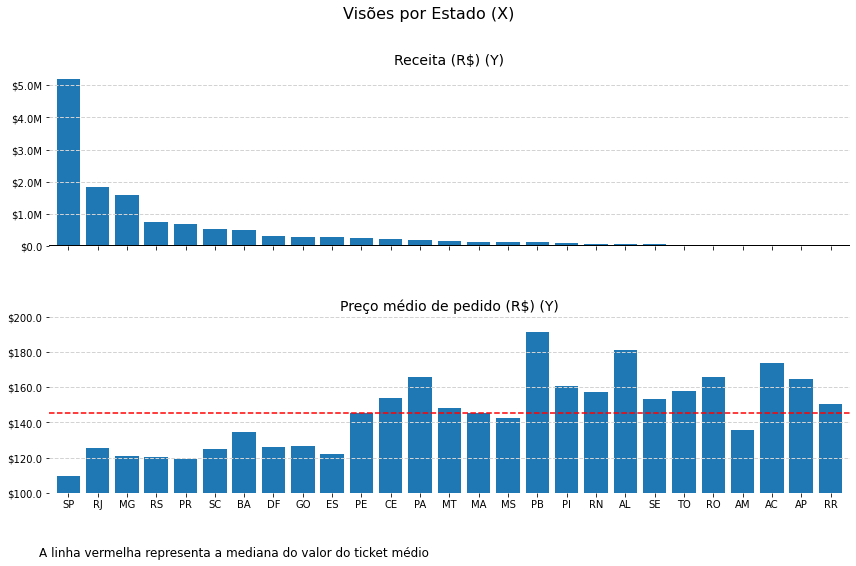

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)

ax = axes[0]
df_analysis_state.plot.bar(x="customer_state", y="revenue", ax=ax, legend=False, width = 0.8)
ax.set_title('Receita (R$) (Y)', fontsize=14)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(reformat_large_tick_values));
ax.set_frame_on(False)
ax.yaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.axhline(0, color='black', linestyle='-', linewidth=2)
ax.set_ylabel("")
ax.set_xlabel("")

ax = axes[1]
df_analysis_state.plot.bar(x="customer_state", y="avg_order_price", ax=ax, legend=False, width = 0.8)
ax.set_title('Preço médio de pedido (R$) (Y)', fontsize=14)
ax.set_ylim([100,200])
ax.axhline(145, c="red", linestyle='dashed', linewidth=1.5)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(reformat_large_tick_values));
ax.set_frame_on(False)
ax.yaxis.grid()
ax.yaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel("")
ax.set_xlabel("")

fig.suptitle(f"Visões por Estado (X)", y=1.02, fontsize=16)

plt.tight_layout()
plt.subplots_adjust(
#                     left=0.5
#                     bottom=0.5, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
                    hspace=0.4)

footnote = f"A linha vermelha representa a mediana do valor do ticket médio"
fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='right', fontsize=12, multialignment="right")

plt.show()

#### Percepções gerais
- Mais de 60% das vendas está concentrada na região sudeste. 
- São Paulo, de longe, é o estado com maior volume de vendas.    
- Nas regiões com o maior volume de receita, o ticket médio é mais baixo.

*** 

### 4.2 Análise por categoria

#### Organizando base de dados

In [137]:
df_analysis_cat = (
    df_analysis
    .groupby("product_category_name")
    .agg(
        revenue=("price", "sum"),
        qnty=("order_id", "count"),
        qnty2=("order_id", "nunique")
        )
    .reset_index()
    .assign(revenue_share=lambda x: np.round(100*x['revenue']/x['revenue'].sum(),2),
           avg_order_price=lambda x: np.round(x['revenue']/x['qnty'], 2)
           )
    .sort_values("revenue_share", ascending=False)
)

df_analysis_cat.head()

,product_category_name,revenue,qnty,qnty2,revenue_share,avg_order_price
11,beleza_saude,1258681.34,9670,8836,9.38,130.16
66,relogios_presentes,1205005.68,5991,5624,8.98,201.14
13,cama_mesa_banho,1036988.68,11115,9417,7.73,93.30
32,esporte_lazer,988048.97,8641,7720,7.37,114.34
44,informatica_acessorios,911954.32,7827,6689,6.80,116.51


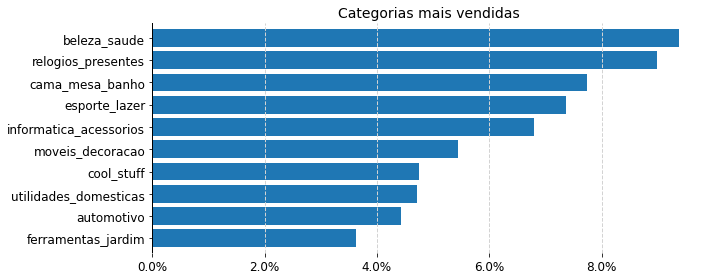

In [149]:
ax = (
    df_analysis_cat
    .head(10)
    .sort_values("revenue_share", ascending=True)
    .plot
    .barh(
        x="product_category_name", 
        y="revenue_share", 
        figsize=(10,4), 
        legend=False,
        width=.8
    )
)
ax.set_title(f'Categorias mais vendidas', fontsize=14)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.xaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("")
ax.set_xlabel("")
plt.box(False)
plt.tight_layout()
plt.show()

***

## 5. Análise temporal

#### Organizando a base de dados

In [40]:
# # customers -- (customer_id) -- orders
# df = customers.merge(orders, on=['customer_id'])[['order_id', 'customer_state', 'order_approved_at']]

# # Fazendo o segundo join
# df = df.merge(order_items, on=['order_id'])[['customer_state', 'order_approved_at','price', 'product_id']]

# # Fazendo o terceiro join
# df = df.merge(products, on=['product_id'])[['customer_state', 'price', 'order_approved_at', 'product_category_name']]

#### Adicionando coluna de mês/ano

In [41]:
# df['data'] = pd.to_datetime(df['order_approved_at'], format="%Y-%m-%d").dt.strftime('%Y/%m')
# df['dia'] = pd.to_datetime(df['order_approved_at'], format="%Y-%m-%d").dt.strftime('%d')

# vendas_df = df

***

### 5.1 Receita por mês

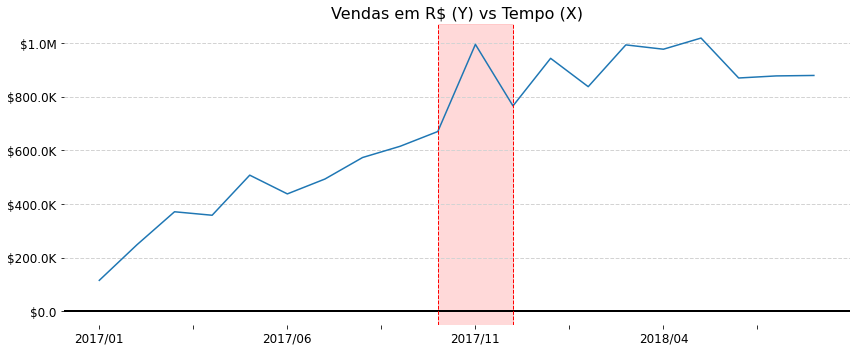

In [227]:
df_analysis_rev = (
    df_analysis
    .query("order_approved_at > '2017-01-01'")
    .query("order_approved_at < '2018-09-01'")
    .groupby("year_month")
    .agg(revenue=("price", "sum"))
    .reset_index()
    .sort_values("year_month")
)

ax = (
    df_analysis_rev
    .plot(x="year_month", y="revenue", legend=False, figsize=(12,5))
)
ax.set_title(f'Vendas em R$ (Y) vs Tempo (X)', fontsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(reformat_large_tick_values));
ax.yaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.axhline(0, color='black', linestyle='-', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)

idx1 = df_analysis_rev.index[df_analysis_rev['year_month'] == "2017/10"]
ax.axvline(idx1, c="red", linestyle='dashed', linewidth=1)

idx2 = df_analysis_rev.index[df_analysis_rev['year_month'] == "2017/12"]
ax.axvline(idx2, c="red", linestyle='dashed', linewidth=1)

ax.axvspan(idx1.values[0], idx2.values[0], alpha=0.15, color='red', ymin=0)

ax.set_ylabel("")
ax.set_xlabel("")
plt.box(False)
plt.tight_layout()
plt.show()

Ao longo do período de análise tivemos alguns picos, o que mais chamou atenção foi o de novembro de 2017.   
Vamos analisar esse mês com mais detalhe nas análises seguintes.
    

#### Detalhando novembro

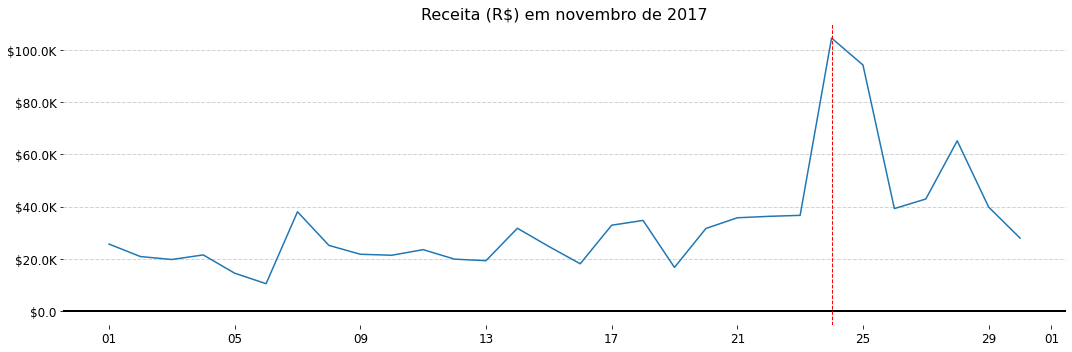

In [263]:
myFmt = mdates.DateFormatter('%d')

df_analysis_rev = (
    df_analysis
    .query("year_month == '2017/11'")
    .groupby("order_date")
    .agg(revenue=("price", "sum"))
    .reset_index()
    .sort_values("order_date")
)

ax = (
    df_analysis_rev
    .plot(x="order_date", y="revenue", legend=False, figsize=(15,5))
)
ax.set_title(f'Receita (R$) em novembro de 2017', fontsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(reformat_large_tick_values));
ax.yaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.axhline(0, color='black', linestyle='-', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.xaxis.set_major_formatter(myFmt)
# ax.xaxis.set_major_locator(plt.MaxNLocator(8))

ax.axvline("2017-11-24", c="red", linestyle='dashed', linewidth=1)

ax.set_ylabel("")
ax.set_xlabel("")
plt.box(False)
plt.tight_layout()
plt.show()

Analisando em detalhes o mês de novembro, conseguimos ver claramente um pico nas vendas nos dias 24 e 25.   
Isso mostra uma **correlação clara com a black friday**, que ocorreu no dia 25/11.

***

## 5.2 Categorias mais vendidas por mês

#### Reorganizando os dados

In [269]:
categorias_mais_vendidas = ['beleza_saude', 'relogios_presentes', 'cama_mesa_banho',
                            'esporte_lazer', 'informatica_acessorios', 'moveis_decoracao', 
                            'cool_stuff', 'utilidades_domesticas', 'automotivo', 'ferramentas_jardim']

df_analysis_rev_cat = (
    df_analysis
    .query("order_approved_at > '2017-01-01'")
    .query("order_approved_at < '2018-09-01'")
    .groupby(["product_category_name", "year_month"])
    .agg(revenue=("price", "sum"))
    .reset_index()
    .query("product_category_name in @categorias_mais_vendidas")
    .pivot(index="year_month", columns="product_category_name", values="revenue")
    .fillna(0.0)
    .reset_index()
)

df_analysis_rev_cat.head()

product_category_name,year_month,automotivo,beleza_saude,cama_mesa_banho,cool_stuff,esporte_lazer,ferramentas_jardim,informatica_acessorios,moveis_decoracao,relogios_presentes,utilidades_domesticas
0,2017/01,5126.43,10810.98,3780.36,7784.87,9602.64,7856.95,3872.24,13380.51,8086.52,2783.08
1,2017/02,13254.50,24484.34,15933.94,12653.94,16303.76,13105.61,12024.49,19954.02,11086.75,12547.37
2,2017/03,14482.07,26030.14,26167.62,21524.90,26996.09,21712.05,28508.84,24225.31,25414.92,13550.32
3,2017/04,15354.38,21614.40,23669.90,21822.08,23922.65,22944.68,20432.02,21116.48,22967.41,15113.15
4,2017/05,18734.82,44732.72,33884.44,33097.50,37061.18,20792.96,45887.79,24171.01,40403.19,21161.70


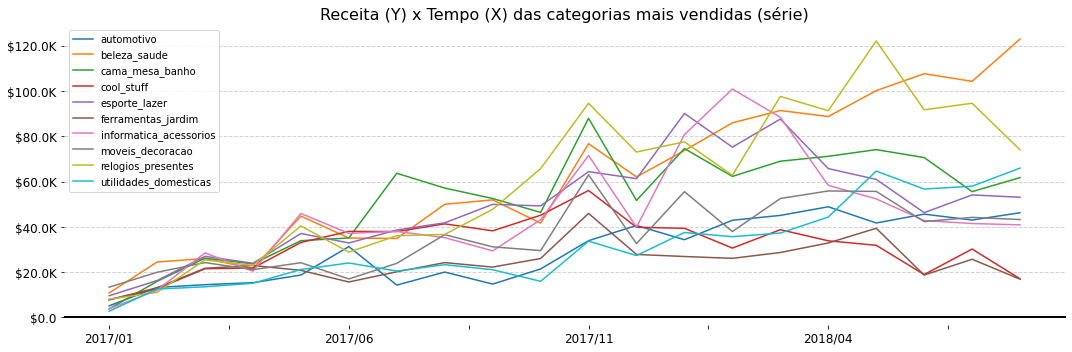

In [279]:
ax = (
    df_analysis_rev_cat.plot(x="year_month", figsize=(15,5))
)

ax.set_title(f'Receita (Y) x Tempo (X) das categorias mais vendidas (série)', fontsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(reformat_large_tick_values));
ax.yaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.axhline(0, color='black', linestyle='-', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("")
ax.set_xlabel("")
legend = plt.legend(title = "")

plt.box(False)
plt.tight_layout()
plt.show()

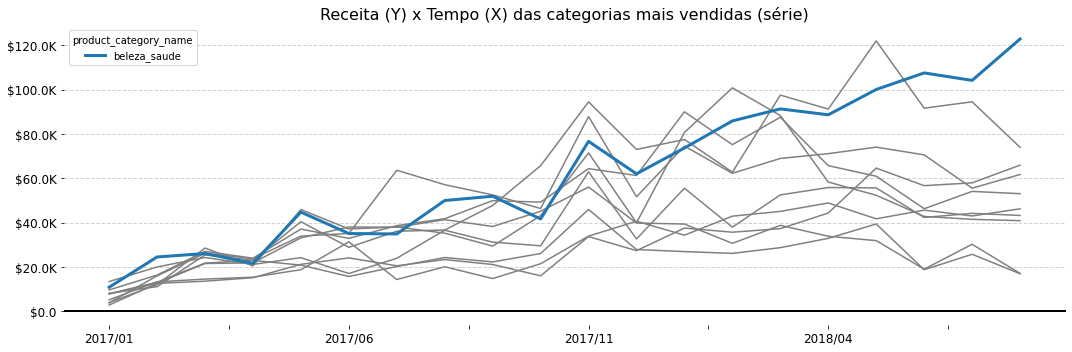

In [295]:
ax = (
    df_analysis_rev_cat
    .drop("beleza_saude", axis=1)
    .plot(x="year_month", figsize=(15,5), color="grey", legend=False)
)

ax.set_title(f'Receita (Y) x Tempo (X) das categorias mais vendidas (série)', fontsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(reformat_large_tick_values));

ax.axhline(0, color='black', linestyle='-', linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)

(
    df_analysis_rev_cat[["year_month", "beleza_saude"]]
    .plot(x="year_month", legend=True, ax=ax, linewidth=3)
)
ax.yaxis.grid(color='lightgrey', linestyle='--', linewidth=1)
ax.set_ylabel("")
ax.set_xlabel("")

plt.box(False)
plt.tight_layout()
plt.show()

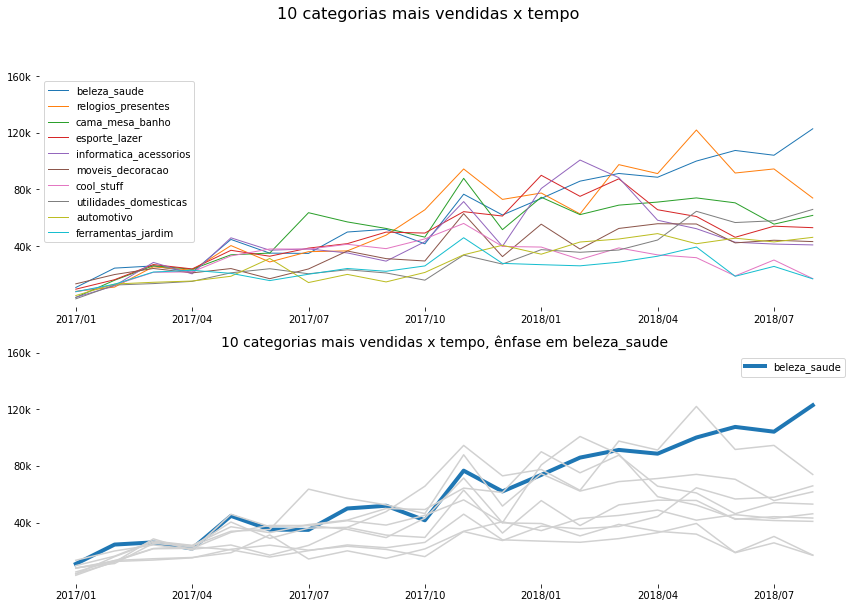

In [38]:
categorias_mais_vendidas = ['beleza_saude', 'relogios_presentes', 'cama_mesa_banho',
                            'esporte_lazer', 'informatica_acessorios', 'moveis_decoracao', 
                            'cool_stuff', 'utilidades_domesticas', 'automotivo', 'ferramentas_jardim']

plt.figure(figsize=(12, 8))
plt.suptitle(f'10 categorias mais vendidas x tempo', y=1.05, fontsize=16)

plt.subplot(211) 
for categoria in categorias_mais_vendidas:
    plt.plot(df.index, df[categoria], label=categoria, linewidth=1)

plt.xticks(df.index[::3].tolist())
plt.yticks([40000, 80000, 120000, 160000], labels =['40k', '80k', '120k', '160k'])
plt.box(False)
plt.legend()   

plt.subplot(212)
for categoria in categorias_mais_vendidas:
    if categoria not in ['beleza_saude']:
        plt.plot(df.index, df[categoria],  color='#D1D1D1')
    else:
        plt.plot(df.index, df[categoria], label=categoria, linewidth=4)
      
plt.title('10 categorias mais vendidas x tempo, ênfase em beleza_saude', fontdict={'fontsize': 14})             
plt.xticks(df.index[::3].tolist())
plt.yticks([40000, 80000, 120000, 160000], labels =['40k', '80k', '120k', '160k'])
plt.legend()

plt.tight_layout()
plt.box(False)
plt.show()

Analisando a evolução das 10 categorias mais vendidas no tempo, a categoria `beleza_saude` chama bastante atenção. Enquanto as outras categorias tiveram um comportamento muito instável, essa categoria permaneceu com um crescimento positivo em praticamente todos os meses. Além disso, hoje ela já é a categoria mais vendida. Vale a pena olhar com atenção para isso e, possivelmente investir mais no crescimento dessa categoria. 
     

***

## 6. Logística

Nessa seção vamos analisar os dados de entregas e tentar responder as seguintes perguntas:

- Qual é o percentual de pedidos atrasados?
- Existe alguma relação entre o tempo medio de entrega e a venda por estado?
- Existe algum estado que atrasa mais as entregas?
- Quais são as etapas que mais influenciam no prazo das entregas?  
	- postagem - responsabilidade do vendedor
	- entrega - responsabilidade da transportadora



In [51]:
# order_items -- (product_id) -- products
df = order_items.merge(products, on=['product_id'])[['order_id', 'product_category_name', 'price']]

# order_items -- (order_id) -- orders
df = df.merge(orders, on=['order_id'])

# Limpando colunas desnecessárias para análise
df = df[['product_category_name','price', 'order_approved_at', 'order_delivered_carrier_date',
         'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_id']]

# # customers -- (customer_id) -- orders
df = df.merge(customers, on=['customer_id'])

# Limpando colunas desnecessárias para análise
df = df[['product_category_name', 'customer_state','price','order_approved_at', 'order_delivered_carrier_date',
         'order_delivered_customer_date', 'order_estimated_delivery_date']]

In [52]:
import datetime

# Convertendo os datas para datetime
df['order_approved'] = pd.to_datetime(df['order_approved_at'])
df['estimated_delivery'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['delivery_carrier'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['delivery_customer'] = pd.to_datetime(df['order_delivered_customer_date'])

# Criando colunas para entender o tempo entre cada etapa do processo de entrega
df['approved_to_customer'] = df['delivery_customer'] - df['order_approved']
df['approved_to_carrier'] = df['delivery_carrier'] - df['order_approved']
df['carrier_to_customer'] = df['delivery_customer'] - df['delivery_carrier']
df['delivered_vs_estimated'] = df['estimated_delivery'] - df['delivery_customer']

No código acima, estamos criando colunas para calcular o tempo de cada etapa da entrega.
***

Pedido aprovado -> Pedido entregue à transportadora -> Pedido entregue ao cliente
***
- `approved_to_customer`- tempo entre a aprovação do pedido e a entrega para o cliente
- `approved_to_carrier` - tempo entre a aprovação do pedido e a entrega para a transportadora
- `carrier_to_costumer` - tempo de entrega da transportadora para o cliente    
     
Vale notar que approved_to_customer = approved_to_carrier + carrier_to_customer
*** 
- `delivered_vs_estimated` - compara o tempo estimado de entrega com o tempo final da entrega

In [53]:
df.describe()

,price,approved_to_customer,approved_to_carrier,carrier_to_customer,delivered_vs_estimated
count,112650.00,110181,111441,110195,110196
mean,120.65,12 days 00:49:18.372596001,2 days 20:25:12.713193528,9 days 04:31:12.436399110,11 days 07:59:44.110657374
std,183.63,9 days 09:54:34.010888983,3 days 14:08:18.514067469,8 days 15:00:15.165039775,10 days 03:53:46.355995898
min,0.85,-7 days +00:14:54,-172 days +18:44:38,-17 days +21:41:31,-189 days +00:35:53
25%,39.90,6 days 06:42:37,0 days 21:11:38,4 days 01:27:39.500000,6 days 11:26:35.750000
50%,74.99,9 days 19:05:03,1 days 20:07:26,7 days 01:25:10,12 days 01:07:22.500000
75%,134.90,15 days 00:57:53,3 days 15:23:02,11 days 21:50:38.500000,16 days 07:42:18
max,6735.00,208 days 12:01:24,125 days 18:18:06,205 days 04:35:00,146 days 00:23:13


**Temos uma inconsistência aqui:** observando a linha `min` temos tempos de entrega negativos. Precisamos tratar esses dados antes de seguir com a análise

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   product_category_name          111047 non-null  object         
 1   customer_state                 112650 non-null  object         
 2   price                          112650 non-null  float64        
 3   order_approved_at              112635 non-null  object         
 4   order_delivered_carrier_date   111456 non-null  object         
 5   order_delivered_customer_date  110196 non-null  object         
 6   order_estimated_delivery_date  112650 non-null  object         
 7   order_approved                 112635 non-null  datetime64[ns] 
 8   estimated_delivery             112650 non-null  datetime64[ns] 
 9   delivery_carrier               111456 non-null  datetime64[ns] 
 10  delivery_customer              110196 non-null  datetime

In [55]:
# Eliminando as colunas negativas
df = df.drop(df[df.approved_to_customer < datetime.timedelta(0)].index)
df = df.drop(df[df.approved_to_carrier < datetime.timedelta(0)].index)
df = df.drop(df[df.carrier_to_customer < datetime.timedelta(0)].index)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111049 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   product_category_name          109457 non-null  object         
 1   customer_state                 111049 non-null  object         
 2   price                          111049 non-null  float64        
 3   order_approved_at              111034 non-null  object         
 4   order_delivered_carrier_date   109855 non-null  object         
 5   order_delivered_customer_date  108604 non-null  object         
 6   order_estimated_delivery_date  111049 non-null  object         
 7   order_approved                 111034 non-null  datetime64[ns] 
 8   estimated_delivery             111049 non-null  datetime64[ns] 
 9   delivery_carrier               109855 non-null  datetime64[ns] 
 10  delivery_customer              108604 non-null  datetime

**Inconsistência relevante eliminada.** Retirando as datas negativas, nossa tabela saiu de 112650 linhas para 102369 uma **diminuição de 10%**   
Vale pontuar que ainda existem alguns valores impraticáveis, como entregas em segundos. Por ora vamos ignorar essa inconsistência. 

In [57]:
df.describe()

,price,approved_to_customer,approved_to_carrier,carrier_to_customer,delivered_vs_estimated
count,111049.00,108589,109840,108603,108604
mean,120.80,12 days 02:56:45.492434776,2 days 21:40:15.532629278,9 days 05:23:20.709427916,11 days 06:40:51.379829472
std,183.99,9 days 10:11:41.627404464,3 days 12:57:58.996373877,8 days 15:14:38.174248538,10 days 04:14:22.795251759
min,0.85,0 days 12:37:32,0 days 00:00:15,0 days 00:00:00,-189 days +00:35:53
25%,39.90,6 days 08:34:12,0 days 21:48:21.500000,4 days 01:39:37.500000,6 days 10:23:42.750000
50%,74.99,9 days 21:02:38,1 days 20:52:36.500000,7 days 01:38:35,12 days 00:09:07
75%,134.90,15 days 02:46:59,3 days 16:13:39,11 days 22:43:50.500000,16 days 07:06:32.250000
max,6735.00,208 days 12:01:24,125 days 18:18:06,205 days 04:35:00,146 days 00:23:13


***
### 6.1 Relação entre tempo de entrega e receita por estado

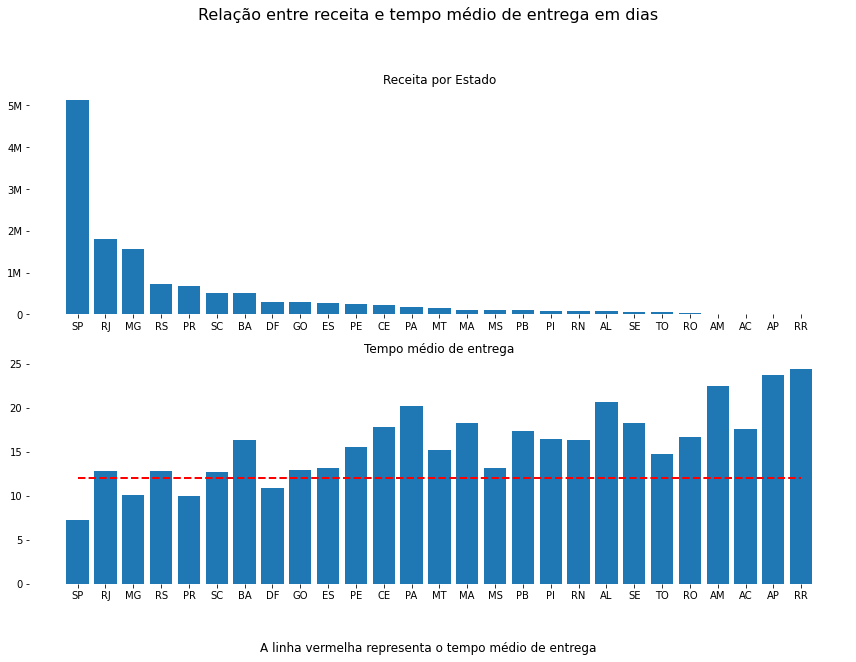

In [58]:
# Agrupando por estado - somando receita e tirando a meedia do tempo de entrega
delivery = df.groupby('customer_state').agg({'price':'sum', 'approved_to_customer': 'mean'}).sort_values(by=['price'],ascending=False)

plt.figure(figsize=(12,8))
plt.suptitle(f"Relação entre receita e tempo médio de entrega em dias", y=1.05, fontsize=16)

plt.subplot(211)
plt.bar(delivery.index, delivery['price'])
plt.title('Receita por Estado')
plt.yticks([0,1e+6,2e+6,3e+6,4e+6,5e+6], labels=['0', '1M', '2M', '3M', '4M', '5M'])
plt.box(False)

plt.subplot(212)
plt.bar(delivery.index, delivery['approved_to_customer'])
plt.title('Tempo médio de entrega')
plt.yticks([0, 5e+14, 10e+14, 15e+14, 20e+14, 25e+14], labels=['0', '5', '10', '15', '20', '25'])
plt.hlines(y = 12e+14,xmin=0, xmax='RR', colors='red', linestyle='dashed', linewidth=2)

footnote = f"A linha vermelha representa o tempo médio de entrega"
fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")

plt.tight_layout()
plt.box(False)
plt.show()

Com base nos gráficos acima, conseguimos perceber de forma clara que, nos estados com maior receita, as entregas são mais rapidas. Principalmente observando o estado de São Paulo.

***

### 6.2 Performance geral das entregas

#### Calculando % de atraso das entregas

In [59]:
atrasos = df

def no_prazo(days):
    if days > datetime.timedelta(0):
        return 'Entregue no prazo'
    elif days < datetime.timedelta(0):
        return 'Entrega atrasada'
    else:
        return 'Não entregue'

atrasos['entregue_no_prazo'] = atrasos['delivered_vs_estimated'].apply(lambda x: no_prazo(x))
atrasos['count'] = 1

In [60]:
atrasos_geral = atrasos.groupby('entregue_no_prazo').sum()

atrasos_geral['%'] = atrasos_geral['count']*100/len(atrasos['count'])
atrasos_geral.head()

,price,count,%
entregue_no_prazo,,,
Entrega atrasada,1154729.10,8680,7.82
Entregue no prazo,11890968.93,99924,89.98
Não entregue,369127.16,2445,2.20


Em geral, cerca de 90% das entregas foram feitas no prazo. 7,8% foram feitas depois do prazo e 2,2% não foram entregues. 

***

### 6.3 Performance das entregas por estado

In [63]:
entregas_estados = atrasos.groupby(['customer_state', 'entregue_no_prazo']).sum()
entregas_estados = entregas_estados.pivot_table(index='customer_state', columns='entregue_no_prazo', values='count')

In [64]:
entregas_estados['total'] = entregas_estados['Entrega atrasada'] + entregas_estados['Entregue no prazo'] 
+ entregas_estados['Não entregue'] 

entregas_estados['% atrasada'] = entregas_estados['Entrega atrasada']*100/entregas_estados['total']
entregas_estados['% no prazo'] = entregas_estados['Entregue no prazo']*100/entregas_estados['total']
entregas_estados['% não entregue'] = entregas_estados['Não entregue']*100/entregas_estados['total']

entregas_estados.head()

entregue_no_prazo,Entrega atrasada,Entregue no prazo,Não entregue,total,% atrasada,% no prazo,% não entregue
customer_state,,,,,,,
AC,3,85,1,88,3.41,96.59,1.14
AL,101,322,17,423,23.88,76.12,4.02
AM,7,155,2,162,4.32,95.68,1.23
AP,4,77,1,81,4.94,95.06,1.23
BA,499,3135,116,3634,13.73,86.27,3.19


***

### 6.4 Performance das entregas por categoria

In [65]:
entregas_cat = atrasos.groupby(['product_category_name', 'entregue_no_prazo']).sum()
entregas_cat = entregas_cat.pivot_table(index='product_category_name', columns='entregue_no_prazo', values='count')

# Adicionando colunas percentuais
entregas_cat['total'] = entregas_cat['Entrega atrasada'] + entregas_cat['Entregue no prazo'] 
+ entregas_cat['Não entregue'] 

entregas_cat['% atrasada'] = entregas_cat['Entrega atrasada']*100/entregas_cat['total']
entregas_cat['% no prazo'] = entregas_cat['Entregue no prazo']*100/entregas_cat['total']
entregas_cat['% não entregue'] = entregas_cat['Não entregue']*100/entregas_cat['total']

entregas_cat.head()

entregue_no_prazo,Entrega atrasada,Entregue no prazo,Não entregue,total,% atrasada,% no prazo,% não entregue
product_category_name,,,,,,,
agro_industria_e_comercio,9.00,195.00,6.00,204.00,4.41,95.59,2.94
alimentos,49.00,441.00,11.00,490.00,10.00,90.00,2.24
alimentos_bebidas,17.00,250.00,9.00,267.00,6.37,93.63,3.37
artes,15.00,179.00,12.00,194.00,7.73,92.27,6.19
artes_e_artesanato,2.00,21.00,NaN,23.00,8.70,91.30,NaN


***


### 6.5 Etapas do processo de entregas

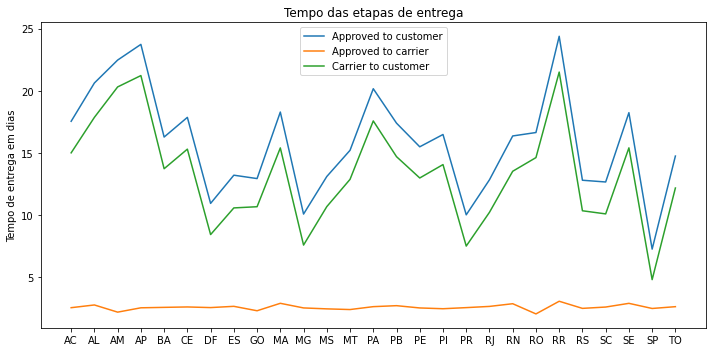

In [66]:
delivery = df.groupby('customer_state')[['approved_to_customer','approved_to_carrier',
                                        'carrier_to_customer','delivered_vs_estimated' ]].mean()
plt.figure(figsize=(10,5))

plt.title('Tempo das etapas de entrega')
plt.ylabel('Tempo de entrega em dias')
plt.yticks([0, 5e+14, 10e+14, 15e+14, 20e+14, 25e+14], labels=['0', '5', '10', '15', '20', '25'])

plt.plot(delivery.index, delivery.approved_to_customer, label= 'Approved to customer')
plt.plot(delivery.index, delivery.approved_to_carrier, label='Approved to carrier')
plt.plot(delivery.index, delivery.carrier_to_customer, label='Carrier to customer')

plt.legend()
plt.tight_layout()
plt.show()

   
Com esse gráfico podemos perceber de forma clara que o tempo de entrega não varia por conta do tempo de postagem, que é responsabilidade do vendedor do produto. Na realidade, o tempo de entrega acompanha as variações do tempo de transporte. Isso indica que, caso queiramos reduzir o tempo de entregas, precisamos focar na etapa que é de responsabilidade das transportadoras.  
   

***